# Import

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from google.colab import drive
drive.mount('/content/drive') 

BASE_PATH = '/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon'
DATA_PATH = BASE_PATH + '/data'

# Paths to input data
IMAGE_PATH = DATA_PATH + '/20210417144750'
IMAGE_GLOB_PATH = IMAGE_PATH + '/*.tif'
METADATA_PATH = DATA_PATH + '/output3.csv'

# Paths for output data
TENSORBOARD_PATH = BASE_PATH + '/logs'
MODEL_PATH = BASE_PATH + '/models'

# Max size of the training dataset to use (None to use all available data)
TRAINING_DATA_SIZE = 1000

# Size of the images being used
TARGET_SIZE = (200, 200)

# Batch size for training
BATCH_SIZE = 10

pprint(os.listdir(BASE_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['data',
 'tensorflow',
 'Report draft.gdoc',
 'models',
 'logs',
 'modelsstd_scaler.bin',
 'std_scaler.bin',
 'datamapping.csv',
 'report template.gdoc']


# Loading model

In [8]:
PATH_TO_H5 = MODEL_PATH + '/2021-04-17_16:39:32/checkpoints/model.09-0.0272.h5'
model = tf.keras.models.load_model(PATH_TO_H5)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

# Making predictions

{'F': array([1., 0., 0.]), 'HR': array([0., 1., 0.]), 'LR': array([0., 0., 1.])}


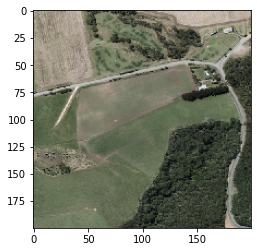

,weather,brightness,speed,severity
0,F,0.0,10,0.076277
1,F,0.0,20,0.078157
2,F,0.0,30,0.080038
3,F,0.0,40,0.081919
4,F,0.0,50,0.083800
...,...,...,...,...
192,LR,1.0,60,0.140129
193,LR,1.0,70,0.142009
194,LR,1.0,80,0.143890
195,LR,1.0,90,0.145771


In [17]:
from sklearn.externals.joblib import load
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import itertools
import timeit

sc = load('/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon/std_scaler.bin')
mapping = pd.read_csv('/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon/datamapping.csv')
mapping = { col: np.array(mapping[col]) for col in mapping.columns }
pprint(mapping)

TEST_IMAGE_PATH = '/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon trial/DATA/train/smol_set/9.tif'

## Input format
# First 6 = One hot weather (one hot)
# Brightness (standard scaler)
# Speed (standard scalar)

def load_image(filepath, target_size=TARGET_SIZE):
  return img_to_array(load_img(filepath, target_size=target_size))


def test_permutations(filepath, datapoints=6):
  # Load, rescale, and reshape image input
  image = load_image(TEST_IMAGE_PATH)
  image /= 255

  # Generate all possible metadata inputs up to a certain precision
  weather = mapping.keys()
  brightness = np.linspace(0, 1, datapoints)
  speed = list(range(10, 111, 10))

  metadata = list(itertools.product(weather, brightness, speed))
  size = len(metadata)

  images = np.array([image] * size)
  inputs = np.array([np.concatenate([mapping[elem[0]], [elem[1]], [elem[2]]]) for elem in metadata])
  inputs = sc.transform(inputs)

  results = {
      'weather': list(map(lambda x: x[0], metadata)),
      'brightness': list(map(lambda x: x[1], metadata)),
      'speed': list(map(lambda x: x[2], metadata)),
      'severity': [elem[0] for elem in model.predict([images, inputs])]
  }

  return pd.DataFrame(results)


plt.imshow(load_image(TEST_IMAGE_PATH) / 255)
plt.show()

# fname = '123_456'
# lat, long = map(float, fname.split('_'))
# print('lat =', lat, 'long =', long)
results = test_permutations(TEST_IMAGE_PATH)
# results.to_csv('predictions.csv')
results[:-1]

In [28]:
#results.weather[:,results.weather =='F']

#df = pd.DataFrame({"cats":["a","b"], "vals":[1,2]})
results.weather = results.weather.astype("category")
results[results.weather.cat.categories == ['F']]

ValueError: ignored

In [14]:
results.describe()

,brightness,speed,severity
count,198.000000,198.000000,198.000000
mean,0.500000,60.000000,0.109400
std,0.342431,31.702936,0.022592
min,0.000000,10.000000,0.076277
25%,0.200000,30.000000,0.091915
50%,0.500000,60.000000,0.102392
75%,0.800000,90.000000,0.133639
max,1.000000,110.000000,0.149532
